In [134]:
import datetime
import xarray  as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [135]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='nRec', combine='nested', parallel=True)
    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/raw/2010/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp


<xarray.Dataset> Size: 65GB
Dimensions:       (nRec: 261165, nObs: 1200, vComp: 3)
Dimensions without coordinates: nRec, nObs, vComp
Data variables: (12/34)
    npnt          (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    year          (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    doy           (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    time          (nRec) float32 1MB dask.array<chunksize=(720,), meta=np.ndarray>
    avgint        (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    kmax          (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    ...            ...
    del_db_geo    (nRec, nObs, vComp) float64 8GB dask.array<chunksize=(720, 1200, 3), meta=np.ndarray>
    del_jPar      (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Th  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Th  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Ph  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Ph  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
Attributes:
    title:        Ampere data for 2010-01-01 00:00 - 2010-01-02 00:00.
    description:  AMPERE GRD data (fitted magnetic pertubation data).
    created:      2022-09-09T21:01:40-04:00

In [136]:
def create_datetime(ds):

    ds = ds.copy()

    fractional_hours = ds['time'].values
    year = ds['year'].values
    doy = ds['doy'].values

    #fractional_hours = [i/30 for i in range(720)]
    df = pd.DataFrame({'fractional_hours': fractional_hours})
    df['hours'] = df['fractional_hours'].apply(lambda x: int(x))
    df['minutes'] = df['fractional_hours'].apply(lambda x: int((x * 60) % 60))
    df['time'] = df.apply(lambda row: f"{int(row['hours']):02}:{int(row['minutes']):02}", axis=1)
    df['doy'] = doy
    df['year'] = year

    def doy_year_to_date(year, doy):
        return datetime.datetime(year, 1, 1) + datetime.timedelta(int(doy) - 1)

    df['date'] = df.apply(lambda row: doy_year_to_date(row['year'], row['doy']), axis=1)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    dt  = pd.to_datetime(df['date'] + ' ' + df['time'])

    ds['dt'] = dt
    
    #ds = ds.set_coords('dt')
    ds = ds.sortby('dt')

    return ds

open_amp = create_datetime(open_multi_amp)
open_amp

<xarray.Dataset> Size: 65GB
Dimensions:       (nRec: 261165, nObs: 1200, vComp: 3, dim_0: 261165)
Coordinates:
  * dim_0         (dim_0) int64 2MB 0 1 2 3 4 ... 261161 261162 261163 261164
Dimensions without coordinates: nRec, nObs, vComp
Data variables: (12/35)
    npnt          (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    year          (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    doy           (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    time          (nRec) float32 1MB dask.array<chunksize=(720,), meta=np.ndarray>
    avgint        (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    kmax          (nRec) int16 522kB dask.array<chunksize=(720,), meta=np.ndarray>
    ...            ...
    del_jPar      (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Th  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Th  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Th_Ph  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    del_db_Ph_Ph  (nRec, nObs) float64 3GB dask.array<chunksize=(720, 1200), meta=np.ndarray>
    dt            (dim_0) datetime64[ns] 2MB 2010-01-01 ... 2010-12-31T23:58:00
Attributes:
    title:        Ampere data for 2010-01-01 00:00 - 2010-01-02 00:00.
    description:  AMPERE GRD data (fitted magnetic pertubation data).
    created:      2022-09-09T21:01:40-04:00

In [138]:
def create_new_ds(ds):

    ds = ds.copy()
    jPar = ds['jPar'].values
    dt = ds['dt'].values
    mlat = np.linspace(50, 90, 50)
    mlt = np.linspace(0, 24, 24)

    ds_new = xr.Dataset({'jPar': (['dt','mlat','mlt'], jPar.reshape(-1, 50, 24))},
                        coords={'dt': dt,'mlat': mlat,'mlt': mlt})

    #ds_new = ds_new.sel(dt=slice('2010-08-01 00:00:00', '2010-08-01 23:30:00'))

    return ds_new

ds = create_new_ds(open_amp)
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (dt: 261165, mlat: 50, mlt: 24)
Coordinates:
  * dt       (dt) datetime64[ns] 2MB 2010-01-01 ... 2010-12-31T23:58:00
  * mlat     (mlat) float64 400B 50.0 50.82 51.63 52.45 ... 88.37 89.18 90.0
  * mlt      (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 20.87 21.91 22.96 24.0
Data variables:
    jPar     (dt, mlat, mlt) float64 3GB 0.1488 0.3371 ... 0.01465 0.01318

In [139]:
def get_omni(df):
    df = df.copy()
    df['dt'] = df['Timestamp_1min_omni']
    df['dt'] = pd.to_datetime(df['dt'])
    df = df.set_index('dt')
    df = df.drop(columns=['Timestamp_1min_omni','Timestamp_1hr_omni'])

    ds = xr.Dataset.from_dataframe(df)

    return ds

omni_ds = get_omni(pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_1min_2010.csv'))
omni_ds

<xarray.Dataset> Size: 42MB
Dimensions:         (dt: 405056)
Coordinates:
  * dt              (dt) datetime64[ns] 3MB 2010-01-01 ... 2010-12-31T23:53:00
Data variables:
    BX_GSE          (dt) float64 3MB 0.02 0.13 0.14 0.04 ... -3.41 -2.91 -3.79
    BY_GSE          (dt) float64 3MB 2.98 2.96 2.99 3.01 ... 2.69 2.87 3.31 2.36
    BZ_GSE          (dt) float64 3MB -0.39 -0.51 -0.37 ... 0.27 -0.55 -0.15
    flow_speed      (dt) int64 3MB 283 283 283 283 283 ... 322 324 323 323 318
    proton_density  (dt) float64 3MB 3.85 3.85 3.92 3.92 ... 4.02 4.35 4.39 4.41
    AL_INDEX        (dt) int64 3MB -1 -1 -1 -1 -2 -2 ... -41 -40 -39 -39 -38 -37
    AU_INDEX        (dt) int64 3MB 3 3 3 3 3 3 3 3 3 ... 14 15 15 13 11 11 11 11
    SYM_H           (dt) int64 3MB 1 1 1 1 1 1 1 ... -16 -16 -16 -16 -16 -16 -16
    ASY_H           (dt) int64 3MB 10 10 10 10 10 11 11 11 ... 7 8 7 8 8 8 8 8
    F10.7           (dt) int64 3MB 72 72 72 72 72 72 72 ... 87 87 87 87 87 87 87
    Kp              (dt) float64 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.3 0.3 0.3 0.3 0.3
    doy             (dt) int64 3MB 1 1 1 1 1 1 1 ... 365 365 365 365 365 365 365

In [141]:
#merge omni and ampere data
def merge_omni_ampere(omni_ds, ampere_ds):
    ds = xr.merge([omni_ds, ampere_ds], join='right')
    #ds = ds.sel(dt=slice('2010-08-01','2010-08-02'))
    #save ds_new to netcdf
    ds = ds.sortby('dt')
    
    ds.to_netcdf('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2010.nc')
    
    return ds

merge_omni_ampere(omni_ds, ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (dt: 261165, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 2MB 2010-01-01 ... 2010-12-31T23:58:00
  * mlat            (mlat) float64 400B 50.0 50.82 51.63 ... 88.37 89.18 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables: (12/13)
    BX_GSE          (dt) float64 2MB 0.02 0.14 0.07 -0.04 ... nan -3.79 nan nan
    BY_GSE          (dt) float64 2MB 2.98 2.99 3.0 2.88 ... nan 2.36 nan nan
    BZ_GSE          (dt) float64 2MB -0.39 -0.37 -0.46 -0.75 ... -0.15 nan nan
    flow_speed      (dt) float64 2MB 283.0 283.0 283.0 282.0 ... 318.0 nan nan
    proton_density  (dt) float64 2MB 3.85 3.92 4.02 4.1 3.6 ... nan 4.41 nan nan
    AL_INDEX        (dt) float64 2MB -1.0 -1.0 -2.0 -2.0 ... nan -37.0 nan nan
    ...              ...
    SYM_H           (dt) float64 2MB 1.0 1.0 1.0 1.0 1.0 ... nan -16.0 nan nan
    ASY_H           (dt) float64 2MB 10.0 10.0 10.0 11.0 ... nan 8.0 nan nan
    F10.7           (dt) float64 2MB 72.0 72.0 72.0 72.0 ... nan 87.0 nan nan
    Kp              (dt) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.3 nan 0.3 nan nan
    doy             (dt) float64 2MB 1.0 1.0 1.0 1.0 1.0 ... nan 365.0 nan nan
    jPar            (dt, mlat, mlt) float64 3GB 0.1488 0.3371 ... 0.01318

<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_5602/2810310008.py:38: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


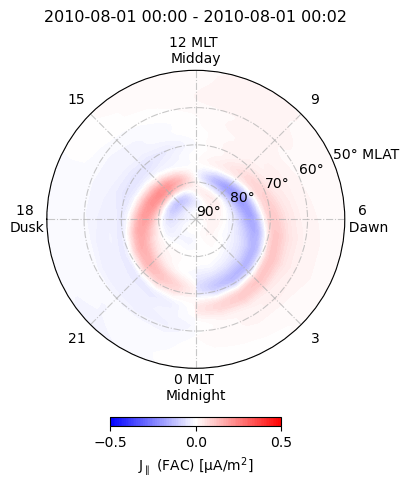

In [119]:
fac = ds['jPar'].mean(dim='dt').values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = open_amp['dt'].values
start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-0.5,.5 , 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{start_time} - {end_time}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-0.5, 0,  0.5], 
             orientation='horizontal')

plt.tight_layout()
#plt.savefig('ampere_20100807.png', dpi=400)